# Thrust vectored AUV

## Extremeley similar to thrust vector rocket landing (a la moda di SpaceX)
![](rocket.png)
![](equations.png)

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state
x, y, vx, vy, theta, omega = symbols('x y vx vy theta omega', real=True)
p = Matrix([x, y])
v = Matrix([vx, vy])
s = Matrix([p, v, [theta], [omega]])
s.T

In [ ]:
# costate variables
# these are just fictitious variables that govern the evolution of the state variables over time
# the optimisation problem is to solve to the optimal initial costate variables
# to evolve the trajectory optimally (wrt lagrangian) to the boundary conditions (e.g. soft landing)
lx, ly, lvx, lvy, ltheta, lomega = symbols('lambda_x lambda_y lambda_v_x lambda_v_y lambda_theta lambda_omega', real=True)
lp = Matrix([lx, ly])
lv = Matrix([lvx, lvy])
l = Matrix([lp, lv, [ltheta], [lomega]])
l.T

In [ ]:
# fullstate
fs = Matrix([s, l])
fs.T

In [ ]:
# params: gravity, max thrust, mass, half length of auv
g, T, m, length, rho, cd, A = symbols('g T m l rho C_d A', real=True, positive=True)
params = Matrix([g, T, m, length, rho, cd, A])
params.T

In [ ]:
# homotopy parameter
alpha = symbols('alpha')
alpha

In [ ]:
# actions
ut = symbols('u_t', real=True, positive=True)
ux, uy = symbols('u_x u_y', real=True)
u = Matrix([ut, ux, uy])
u.T

In [ ]:
# thrust vector tilt wrt global frame
#t = Matrix([cos(theta + phi), sin(theta + phi)])
t = Matrix([ux, uy])

# rocket orientation wrt horizontal
itheta = Matrix([cos(theta), sin(theta)])

# perpendicular direction to orientation
itau = Matrix([sin(theta), -cos(theta)])

In [ ]:
# gravity
Fg = Matrix([0, -m*g])

# thrust
Ft = T*ut*t

# fluid drag
vinf = v
vinfmag = sqrt(sum([var**2 for var in vinf]))
Fd = - Rational(1,2)*rho*vinf*vinfmag*cd*A

# dynamics
dr = v
dv = (Ft + Fg + Fd)/m
dtheta = omega
domega = (12/m/length**2) * T*ut*length/2 * t.dot(itau)
ds = Matrix([dr, dv, [dtheta], [domega]])
ds

In [ ]:
# dynamic Lagrangian to minimise thrust usage
L = (1- alpha)*ut**2 + alpha*ut
L

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# optimal thrust direction
laux = (lv + lomega*12/length**2*itau)
lauxnorm = sqrt(sum([laux[i]**2 for i in range(len(laux))]))
lauxdir = laux/lauxnorm
tstar = -lauxdir
tstar = simplify(tstar)
tstar

In [ ]:
# new Hamiltonian with optimal thrust direction
Fgs = Matrix([0, -m*g])
Fts = T*ut*tstar
vinfs = v
vinfmags = sqrt(sum([var**2 for var in vinf]))
Fds = - Rational(1,2)*rho*vinf*vinfmag*cd*A
drs = v
dvs = (Fts + Fgs + Fds)/m
dthetas = omega
domegas = (12/m/length**2) * T*ut*length/2 * tstar.dot(itau)
dss = Matrix([drs, dvs, [dthetas], [domegas]])
Hs = l.dot(dss) + L
Hs

In [ ]:
# optimal thrust magnitude (unbounded)
utstar = solve(Hs.diff(ut), ut)[0]
utstar

In [ ]:
ustar = Matrix([[utstar], tstar])
ustar

In [ ]:
# costate equations of motion
dl = -Matrix([H.diff(var) for var in s])

# fullstate
dfs = Matrix([ds, dl])
dfs

In [ ]:
# fullstate Jacobian
ddfs = dfs.jacobian(fs)
ddfs

# Automatic code generation

In [ ]:
from sympy.utilities.codegen import *

In [ ]:
# function names
names = ["lagrangian", "hamiltonian", "pontryagin", "eom_fullstate", "eom_fullstate_jac"]

# function expressions
funcs = [
    Eq(symbols("L"), L),
    Eq(symbols("H"), H),
    Eq(MatrixSymbol("u", *ustar.shape), ustar),
    Eq(MatrixSymbol("dfs", *dfs.shape), dfs),
    Eq(MatrixSymbol("ddfs", *ddfs.shape), ddfs)
]

# function arguments
syms = [
    [*u, alpha],
    [*fs, *u, alpha, *params],
    [*fs, alpha, *params],
    [*fs, *u, *params],
    [*fs, *u, *params]
]
[sym.append(func.lhs) for sym, func in zip(syms, funcs)]

In [ ]:
# code generator
gen = FCodeGen()

# create routines
routines = [gen.routine(name, func, sym, None) for name, func, sym in zip(names, funcs, syms)]

# write routines to file
gen.write(routines, "../src/trajopt/_dynamics", to_files=True, header=False, empty=True)

In [ ]:
# compile source and create python extension
import os
os.system("cd ../src/trajopt && f2py -c -m _dynamics _dynamics.f90 _dynamics.h")

# Test

In [4]:
import numpy as np
import sys
sys.path.append("../src/trajopt")
from dynamics import Dynamics
from leg import Leg
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: TkAgg


In [5]:
# instantiate AUV dynamical system
sys = Dynamics()

In [6]:
# instantiate optimal control leg
leg = Leg(sys, alpha=0.999, bound=True)

In [32]:
# arbitrary boundaries
t0 = 0
s0 = np.array([100, 100, *np.random.randn(4)], dtype=float)
l0 = np.random.randn(len(s0))*100
tf = 10000
sf = np.array([0, 0, 0, 0, 0, 0], dtype=float)

In [33]:
# set boundaries
leg.set(t0, s0, l0, tf, sf)

In [34]:
# propagate dynamics and measure terminal mismatch
leg.mismatch(atol=1e-14, rtol=1e-14)

/usr/local/lib/python3.5/dist-packages/scipy/integrate/_ode.py:1095: UserWarning: dop853: larger nmax is needed
  self.messages.get(istate, unexpected_istate_msg)))


array([ 1.00109657e+02,  9.81434134e+01,  2.02111159e-09, -8.48803079e-01,
        2.31209171e+00,  2.17942260e+00, -6.12761090e+12])

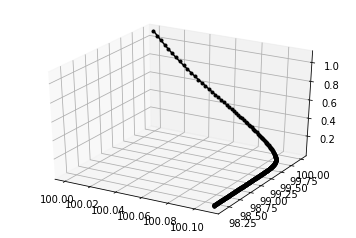

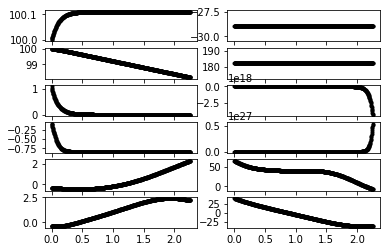

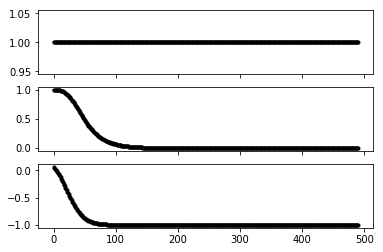

In [35]:
leg.plot_traj()
leg.plot_states()
leg.plot_actions(time=False)
plt.show()

# Optimisation

In [46]:
from problem import Problem
import pygmo as pg
import pygmo_plugins_nonfree as pg7

In [47]:
# define problem
udp = Problem(leg)
prob = pg.problem(udp)

In [48]:
# instantiate algorithm
uda = pg7.snopt7(True, "/usr/lib/libsnopt7_c.so")
uda.set_integer_option("Major iterations limit", 4000)
uda.set_integer_option("Iterations limit", 40000)
uda.set_numeric_option("Major optimality tolerance", 1e-2)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)
algo = pg.algorithm(uda)

In [49]:
# instantiate population
pop = pg.population(prob, 1)

/usr/local/lib/python3.5/dist-packages/scipy/integrate/_ode.py:1095: UserWarning: dop853: larger nmax is needed
  self.messages.get(istate, unexpected_istate_msg)))


In [50]:
# evolve population
pop = algo.evolve(pop)

/usr/local/lib/python3.5/dist-packages/scipy/integrate/_ode.py:1095: UserWarning: dop853: larger nmax is needed
  self.messages.get(istate, unexpected_istate_msg)))
